In [1]:
# importing all the dependencies.
import warnings
warnings.filterwarnings("ignore")
import os
import sys
import random
 
import numpy as np
import pandas as pd
 
import matplotlib.pyplot as plt
 
from tqdm import tqdm
from itertools import chain
import tensorflow as tf
from keras.preprocessing import image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
BATCH_SIZE = 10 
IMG_WIDTH = 128 
IMG_HEIGHT = 128 
IMG_CHANNELS = 3
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

In [4]:
# getting data from drive.
X_train = np.load("/content/drive/My Drive/nuclei_train_x.npy")
Y_train = np.load("/content/drive/My Drive/nuclei_train_y.npy")
X_test = np.load("/content/drive/My Drive/nuclei_test_x.npy")
sizes_test = np.load("/content/drive/My Drive/nuclei_sizes_test.npy")
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(sizes_test.shape)

(670, 128, 128, 3)
(670, 128, 128, 1)
(65, 128, 128, 3)
(65, 2)


## Data Augmentation :

In [13]:
# Creating the training Image and Mask generator

image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)



# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

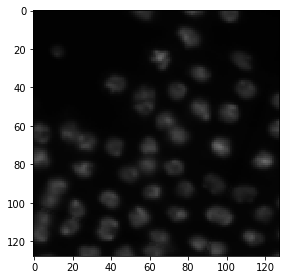

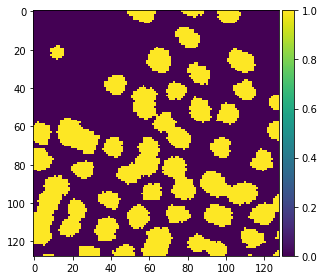

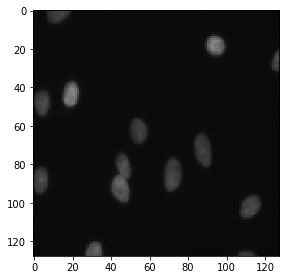

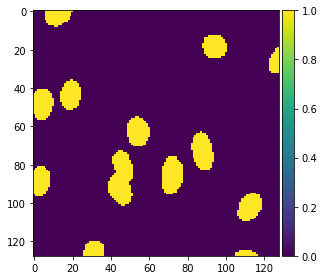

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

imshow(x.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()
imshow(x_val.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

In [14]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [5]:
# computing mean IoU.
def mean_iou(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

## U-Net model Architecture :

In [15]:
# Unet model architecture.
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)) # input layer
s = Lambda(lambda x: x / 255) (inputs)

# Contraction block 1.
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

# contraction block 2.
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

# contraction block 3.
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

# contraction block 4.
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# bottom block between contraction and Expansion blocks.
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

# Expansion block 1.
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

# Expansion block 2.
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

# Expansion block 3.
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

# Expansion block 4.
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# Output layer.
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou]) # compile
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 128, 128, 16) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [16]:
earlystopper = EarlyStopping(patience=4, verbose=1)
checkpointer = ModelCheckpoint('/content/drive/My Drive/Detect_Nuclei_model', verbose=1, save_best_only=True)
# Training model.
results = model.fit_generator(train_generator, validation_data=val_generator, epochs=30, steps_per_epoch=65, validation_steps=5, callbacks=[earlystopper, checkpointer])

Epoch 1/30
65/65 [==============================] - 8s 118ms/step - loss: 0.3640 - mean_iou: 0.3103 - val_loss: 0.1534 - val_mean_iou: 0.5548

Epoch 00001: val_loss improved from inf to 0.15339, saving model to /content/drive/My Drive/Detect_Nuclei_model
Epoch 2/30
65/65 [==============================] - 6s 90ms/step - loss: 0.1764 - mean_iou: 0.5541 - val_loss: 0.4582 - val_mean_iou: 0.6434

Epoch 00002: val_loss did not improve from 0.15339
Epoch 3/30
65/65 [==============================] - 6s 91ms/step - loss: 0.1623 - mean_iou: 0.5967 - val_loss: 0.0970 - val_mean_iou: 0.6987

Epoch 00003: val_loss improved from 0.15339 to 0.09701, saving model to /content/drive/My Drive/Detect_Nuclei_model
Epoch 4/30
65/65 [==============================] - 6s 90ms/step - loss: 0.1751 - mean_iou: 0.5859 - val_loss: 0.2064 - val_mean_iou: 0.6861

Epoch 00004: val_loss did not improve from 0.09701
Epoch 5/30
65/65 [==============================] - 6s 91ms/step - loss: 0.1511 - mean_iou: 0.6259 - 

In [17]:
# load model from disk.
model = load_model("/content/drive/My Drive/Detect_Nuclei_model", custom_objects={'mean_iou':mean_iou})

In [18]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1) # predict on train data.
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1) # predict on val data.
preds_test = model.predict(X_test, verbose=1) # predict on test data.

65/65 [==============================] - 0s 2ms/step


In [19]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), (sizes_test[i][0], sizes_test[i][1]), mode='constant', preserve_range=True))

In [21]:
# Clean image.
from skimage.morphology import closing, opening, disk
def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))

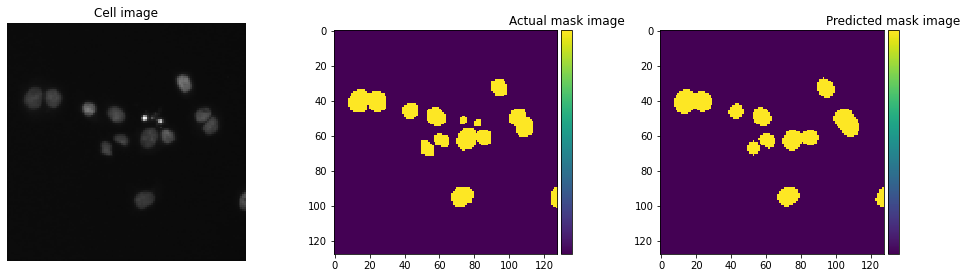

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(13,5))
plt.subplot(1,3,1)
imshow(X_train[5])
plt.title("Cell image")
plt.axis('off')
plt.subplot(1,3,2)
imshow(np.squeeze(Y_train[5].astype(np.uint8)))
plt.title("Actual mask image")
plt.axis("off")
plt.subplot(1,3,3)
imshow(clean_img(np.squeeze(preds_train_t[5])))
plt.title("Predicted mask image")
plt.axis("off")
plt.show()

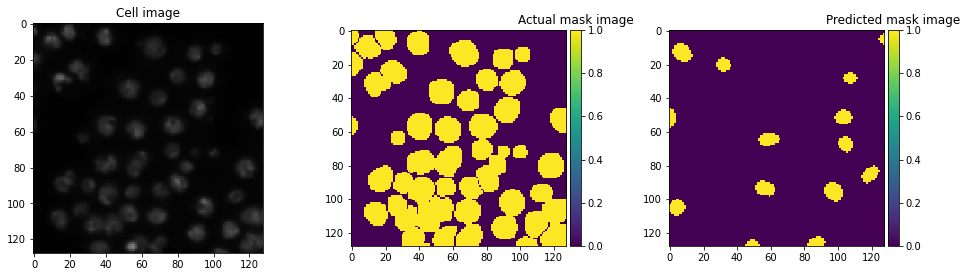

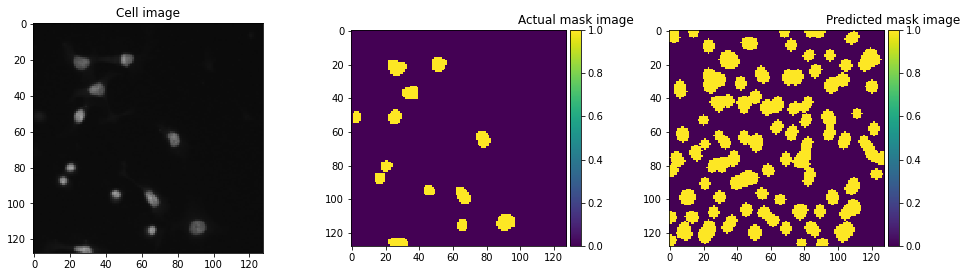

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(13,5))
plt.subplot(1,3,1)
imshow(X_train[662])
plt.title("Cell image")
plt.subplot(1,3,2)
imshow(np.squeeze(Y_train[662].astype(np.uint8)))
plt.title("Actual mask image")
plt.subplot(1,3,3)
imshow(clean_img(np.squeeze(preds_train_t[-8])))
plt.title("Predicted mask image")
plt.show()
plt.figure(figsize=(13,5))
plt.subplot(1,3,1)
imshow(X_train[665])
plt.title("Cell image")
plt.subplot(1,3,2)
imshow(np.squeeze(Y_train[665].astype(np.uint8)))
plt.title("Actual mask image")
plt.subplot(1,3,3)
imshow(clean_img(np.squeeze(preds_train_t[-5])))
plt.title("Predicted mask image")
plt.show()

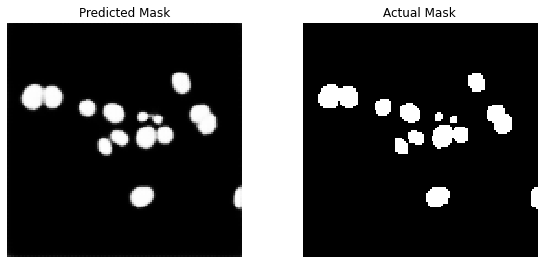

In [27]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
imshow(np.squeeze(model.predict(X_train[5].reshape(1,128,128,3))))
plt.title("Predicted Mask")
plt.axis('off')
plt.subplot(1,2,2)
imshow(np.squeeze(Y_train[5]))
plt.title("Actual Mask")
plt.axis('off')
plt.show()

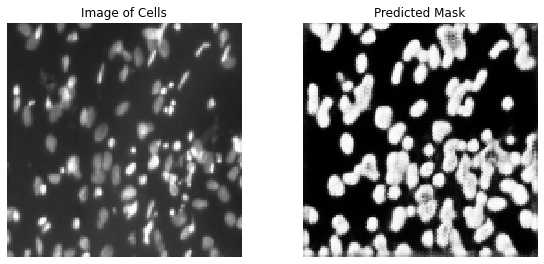

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


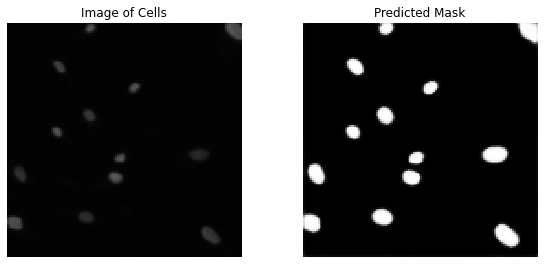

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


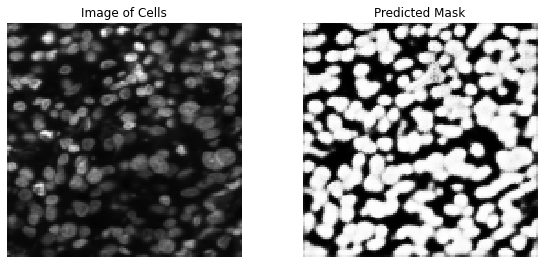

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


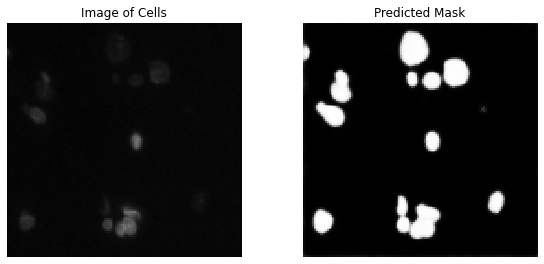

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


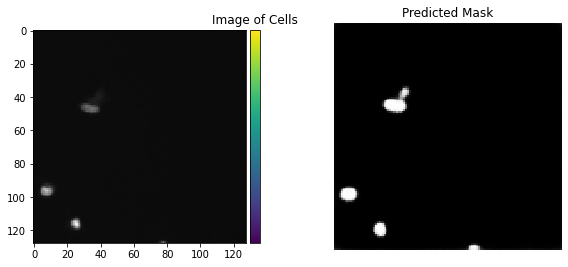

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


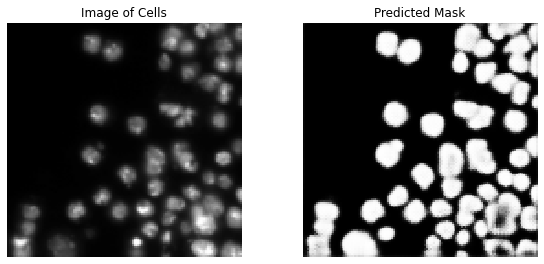

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


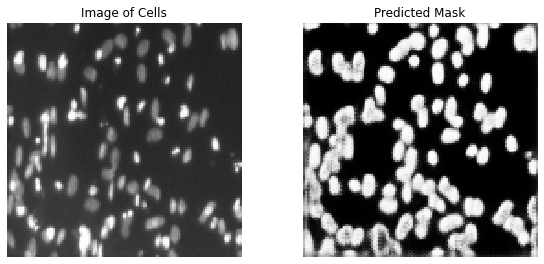

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


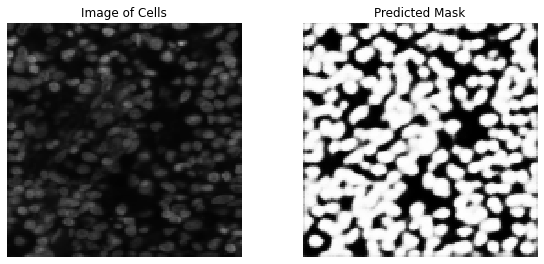

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


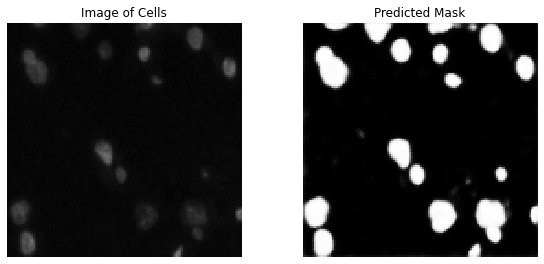

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


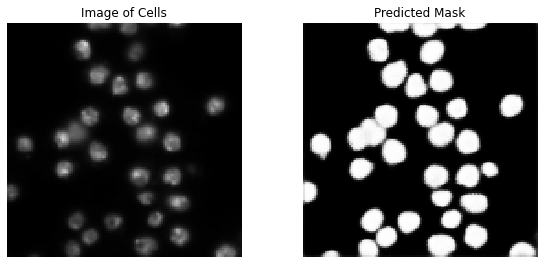

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


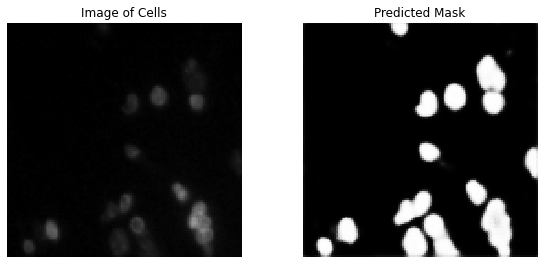

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=


In [29]:
# predicting on some test data.
for i in range(30,41):
  plt.figure(figsize=(8,4))
  plt.subplot(1,2,1)
  imshow(np.squeeze(X_test[i]))
  plt.title("Image of Cells")
  plt.axis('off')
  plt.subplot(1,2,2)
  imshow(np.squeeze(model.predict(X_test[i].reshape(1,128,128,3))))
  plt.title("Predicted Mask")
  plt.axis('off')
  plt.show()
  print("*="*60)